In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

import numpy as np
import xarray as xr
from xgcm import Grid

import matplotlib.pyplot as plt

In [3]:
import xbudget
import regionate
import xwmb

### Load grids and data

In [24]:
gridname = 'natv' #   choose from ['natv', 'rho2', 'zstr']
dt = 'daily' #       choose from ['monthly', 'daily', 'hourly']

In [5]:
# Load data on native grid
sim = "wmt_incsurffluxes.natv_rho2_zstr.monthly_daily_hourly.13months"
rootdir = f"/archive/Graeme.Macgilchrist/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/{sim}/Baltic_OM4_025/"
prefix = '19000101.ocean_'+dt+'_' 
time = "190*"
#time = "1900_02_01"

# Diagnostics were saved into different files
suffixs = ['surf','thck','heat','salt','xtra']
Zprefixes = {'rho2':'rho2_', 'zstr':'z_', 'natv':'z'}
Zprefix = Zprefixes[gridname]
ds = xr.Dataset()
for suffix in suffixs:
    if suffix == "surf":
        filename = prefix+suffix+'_'+time+'.nc'
    else:
        filename = prefix+gridname+'_'+suffix+'_'+time+'.nc'
    dsnow = xr.open_mfdataset(rootdir+filename)
    ds = xr.merge([ds,dsnow])
    
# Load snapshot data (for mass tendency term)
suffix = 'snap'
filename = prefix+gridname+'_'+suffix+'_'+time+'.nc'
snap = xr.open_mfdataset(rootdir+filename)

# Align N+1 snapshots so they bound N averages, and select year-long subset
ds = ds.sel(time=slice(snap.time[0], snap.time[-1]))
ds = ds.sel(time=slice('1900-02-01 00', '1901-02-01 00'))
snap = snap.sel(time=slice('1900-02-01 00', '1901-02-01 00'))

#  Load grid
oceangridname = '19000101.ocean_static.nc'
ocean_grid = xr.open_dataset(rootdir+oceangridname).squeeze()

# Some renaming to match hdrake conventions
ocean_grid = ocean_grid.rename({'depth_ocean':'deptho'})
ds = ds.rename({'temp':'thetao', "salt":'so'})
snap = snap.rename({'temp':'thetao', "salt":'so'})

# Merge snapshots with time-averages
snap = snap.rename({
    **{'time':'time_bounds'},
    **{v:f"{v}_bounds" for v in snap.data_vars}
})
ds = xr.merge([ds, snap])

# Add core coordinates of ocean_grid to ds
ds = ds.assign_coords({
    "wet": xr.DataArray(ocean_grid["wet"].values, dims=('yh', 'xh',)),
    "areacello": xr.DataArray(ocean_grid["areacello"].values, dims=('yh', 'xh',)),
    'xq': xr.DataArray(ocean_grid['xq'].values, dims=('xq',)),
    'yq': xr.DataArray(ocean_grid['yq'].values, dims=('yq',)),
    'geolon': xr.DataArray(ocean_grid['geolon'].values, dims=('yh','xh')),
    'geolat': xr.DataArray(ocean_grid['geolat'].values, dims=('yh','xh')),
    'geolon_u': xr.DataArray(ocean_grid['geolon_u'].values, dims=('yh','xq')),
    'geolat_u': xr.DataArray(ocean_grid['geolat_u'].values, dims=('yh','xq')),
    'geolon_v': xr.DataArray(ocean_grid['geolon_v'].values, dims=('yq','xh')),
    'geolat_v': xr.DataArray(ocean_grid['geolat_v'].values, dims=('yq','xh')),
    'geolon_c': xr.DataArray(ocean_grid['geolon_c'].values, dims=('yq','xq')),
    'geolat_c': xr.DataArray(ocean_grid['geolat_c'].values, dims=('yq','xq')),
    'dxt': xr.DataArray(ocean_grid['dxt'].values, dims=('yh', 'xh',)),
    'dyt': xr.DataArray(ocean_grid['dyt'].values, dims=('yh', 'xh',)),
    'dxCv': xr.DataArray(ocean_grid['dxCv'].values, dims=('yq', 'xh',)),
    'dyCu': xr.DataArray(ocean_grid['dyCu'].values, dims=('yh', 'xq',)),
    'dxCu': xr.DataArray(ocean_grid['dxCu'].values, dims=('yh', 'xq',)),
    'dyCv': xr.DataArray(ocean_grid['dyCv'].values, dims=('yq', 'xh',)),
    'deptho': xr.DataArray(ocean_grid['deptho'].values, dims=('yh', 'xh',)),
})
ds['lon'] = ds.geolon
ds['lat'] = ds.geolat

ds['sigma2_bounds'] = ds['rhopot2_bounds'] - 1000.
ds['sigma2'] = ds['rhopot2'] - 1000.

# z-coordinate dataset containing basic state variables
coords = {
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'center': f'{Zprefix}l', 'outer': f'{Zprefix}i'},
}
metrics = {
    ('X','Y'): "areacello",
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=None)

In [6]:
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6")
xbudget.collect_budgets(ds, budgets_dict)

simple_budgets = xbudget.aggregate(budgets_dict)
simple_budgets['mass']['transport'] = {"X": "umo", "Y": "vmo"}
simple_budgets['mass']['rhs']['surface_exchange_flux'] = 'mass_rhs_surface_exchange_flux_product' # 3D field is more reliable
simple_budgets

{'mass': {'lambda': 'density',
  'thickness': 'thkcello',
  'lhs': {'Eulerian_tendency': 'mass_lhs_Eulerian_tendency_product'},
  'rhs': {'advection': 'mass_rhs_advection_sum',
   'surface_exchange_flux': 'mass_rhs_surface_exchange_flux_product'},
  'transport': {'X': 'umo', 'Y': 'vmo'}},
 'heat': {'lambda': 'thetao',
  'surface_lambda': 'tos',
  'lhs': {'Eulerian_tendency': 'opottemptend',
   'advection': 'heat_lhs_advection_product',
   'surface_ocean_flux_advective_negative_lhs': 'heat_lhs_surface_ocean_flux_advective_negative_lhs_product'},
  'rhs': {'diffusion': 'heat_rhs_diffusion_sum',
   'surface_exchange_flux': 'boundary_forcing_heat_tendency',
   'surface_ocean_flux_advective_negative_rhs': 'heat_rhs_surface_ocean_flux_advective_negative_rhs_product',
   'bottom_flux': 'internal_heat_heat_tendency',
   'frazil_ice': 'frazil_heat_tendency'}},
 'salt': {'lambda': 'so',
  'surface_lambda': 'sos',
  'lhs': {'Eulerian_tendency': 'osalttend',
   'advection': 'salt_lhs_advection_pro

In [7]:
# Note: the properties of this region are quite different from the rest of the Baltic!
name = "intBaltic"
lons = np.array([15.,   20.,  29., 24.5, 24.5, 26.1, 17.5, 11.5])
lats = np.array([53.5, 53.5, 54.5,  59.,  61.,  63., 64.5,  62.])
region = regionate.GriddedRegion(name, lons, lats, grid)

# name = "Baltic"
# region = xr.ones_like(grid._ds['deptho'])

In [8]:
wmb = xwmb.WaterMassBudget(
    grid,
    simple_budgets,
    region
)
toSv = 1.e-6/wmb.rho_ref

In [25]:
import warnings
import os

def fpath(lam):
    return f"/work/hfd/codedev/xwmb/data/budget_{name}_{lam}_{dt}_{gridname}_updated.nc"

wmts = {}
for lam in ["heat", "salt", "sigma2"]:
    if os.path.isfile(fpath(lam)):
        print("Loading pre-computed WMT.")
        wmts[lam] = xr.open_dataset(fpath(lam))

    else:
        print("Computing WMT...")
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            wmb.mass_budget(lam)
            wmb.wmt.load()
            wmb.wmt.to_netcdf(fpath(lam), mode="w")
            wmts[lam] = wmb.wmt

Loading pre-computed WMT.
Loading pre-computed WMT.
Loading pre-computed WMT.


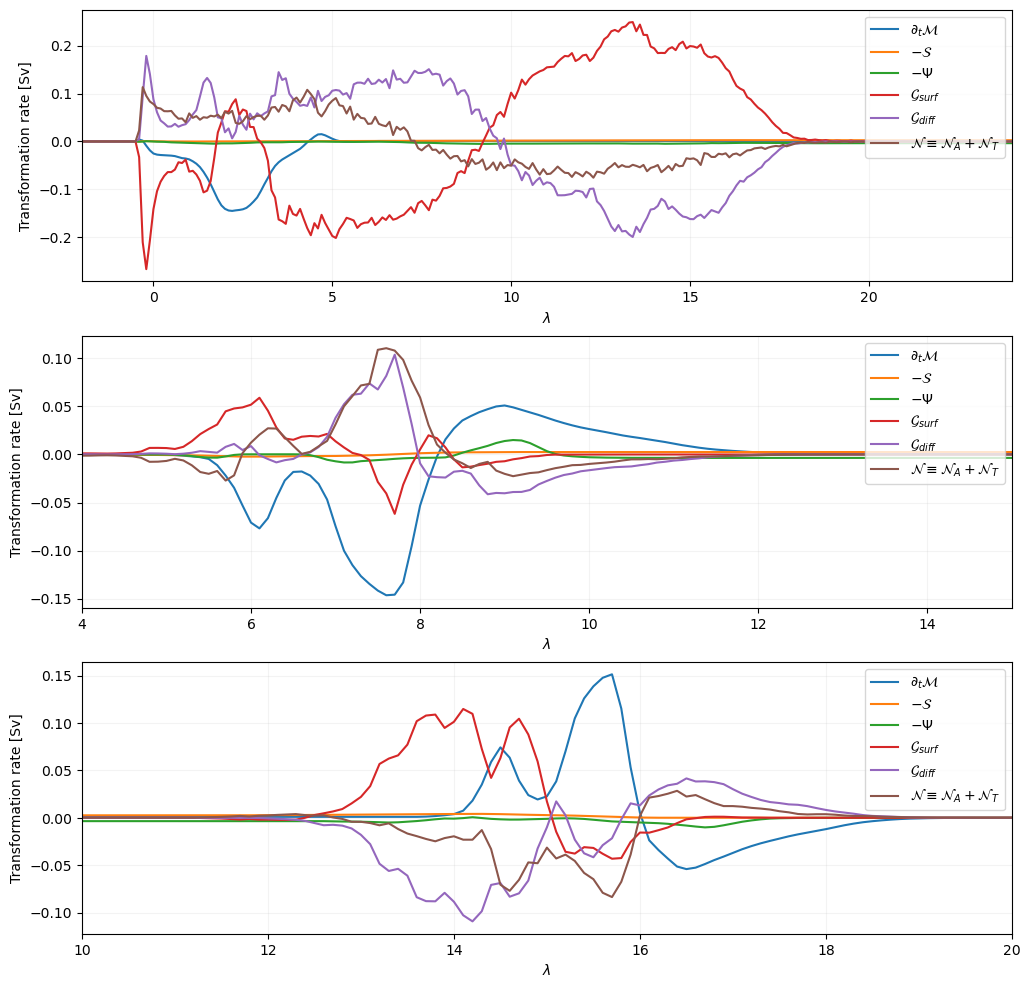

In [39]:
plt.figure(figsize=(12, 12))
for i, (lam, xlims) in enumerate(zip(["heat", "salt", "sigma2"], [[-2, 24], [4, 15], [10, 20]])):
    wmt = wmts[lam]
    plt.subplot(3,1,i+1)
    (wmt['mass_tendency']*toSv).mean('time').plot(label=r"$\partial_{t} \mathcal{M}$")
    (-wmt['mass_source']*toSv).mean('time').plot(label=r"$-\mathcal{S}$")
    (-wmt['overturning']*toSv).mean('time').plot(label=r"$-\Psi$")
    (wmt['boundary_fluxes']*toSv).mean('time').plot(label=r"$\mathcal{G}_{surf}$")
    (wmt['diffusion']*toSv).mean('time').plot(label=r"$\mathcal{G}_{diff}$")
    (wmt['numerical_mixing']*toSv).mean('time').plot(label=r"$\mathcal{N}\equiv \mathcal{N}_{A} + \mathcal{N}_{T}$")
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.15)
    plt.ylabel("Transformation rate [Sv]")
    plt.xlabel(r"$\lambda$");
    plt.xlim(xlims)

In [12]:
Δt = (ds.time_bounds.diff('time_bounds').astype('float')*1.e-9).rename({"time_bounds":"time"}).assign_coords({'time':ds['time']})

(-1.0, 20.0)

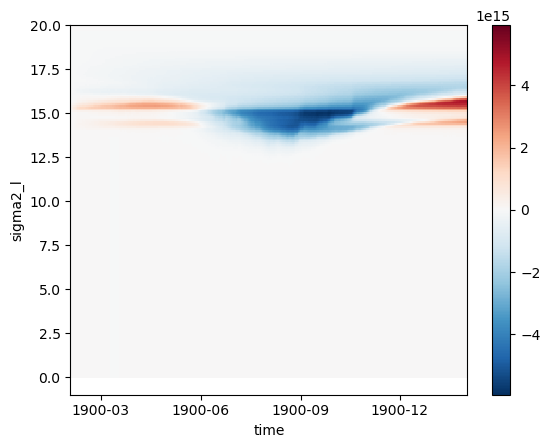

In [13]:
(wmt['mass_tendency']*Δt).cumsum('time').plot(x="time")
plt.ylim(-1, 20)